In [105]:
import numpy as np
import pandas as pd
from collections import Counter

In [211]:
# ID3
class Tree():    
    
    def entropy(self, feature: np.array) -> float:
        entropy = 0
        values, counts = np.unique(feature, return_counts=True)
        total_count = np.sum(counts)
        for i in range(len(values)):
            p = counts[i] / total_count
            entropy -= p * np.log2(p)
        return entropy

    
    def info_gain(self, X: np.array, feature_index: int, y: np.array) -> float:
        info_before_split = self.entropy(y)
        values, counts = np.unique(X[:, feature_index], return_counts=True)
        total_count = np.sum(counts)
        
        info = 0
        for i in range(len(values)):
            subset = y[X[:, feature_index] == values[i]]
            info += (counts[i] / total_count) * self.entropy(subset)
            
        return info_before_split - info

    
    def split(self, X, feature_index, param, y):
        cond = X[:, feature_index] == param
        return X[cond], y[cond]

    
    def fit(self, X: np.array, y: np.array):
        if len(np.unique(y)) <= 1:
            return Node(value=np.unique(y)[0]) # leaf

        features_info_gain = [self.info_gain(X, feature_index, y) for feature_index in range(np.shape(X)[1])]
        
        best_feature_index = np.argmax(features_info_gain)

        best_feature = features[best_feature_index]
        
        root = Node(feature_index=best_feature_index)
        
        for param in np.unique(X[:, best_feature_index]):
            # data after the split
            sub_X, sub_y = self.split(X, best_feature_index, param, y)
            # recursive call
            branch = self.fit(sub_X, sub_y)
            # append branch to the tree
            root.add_child((param, branch))
            
        return root

    def predict_one(self, node, instance):
        if node.value is not None:
            return node.value
        feature_value = instance[node.feature_index]
        for param, child in node.children:
            if feature_value == param:
                return self.predict_one(child, instance)
        return None

    def predict(self, X, root):
        return [self.predict_one(root, instance) for instance in X]
        

class Node():
    def __init__(self, feature_index=None, value=None):
        self.feature_index = feature_index
        self.value = value # if it is a leaf
        self.children = []

    def add_child(self, node) -> None:
        self.children.append(node)

    

In [213]:
dataset = pd.read_csv('play_tennis.csv').dropna()
dataset.drop("day", axis=1, inplace=True)
dataset

,outlook,temp,humidity,wind,play
0,Sunny,Hot,High,Weak,No
1,Sunny,Hot,High,Strong,No
2,Overcast,Hot,High,Weak,Yes
3,Rain,Mild,High,Weak,Yes
4,Rain,Cool,Normal,Weak,Yes
5,Rain,Cool,Normal,Strong,No
6,Overcast,Cool,Normal,Strong,Yes
7,Sunny,Mild,High,Weak,No
8,Sunny,Cool,Normal,Weak,Yes
9,Rain,Mild,Normal,Weak,Yes


In [215]:
categorical_feats = list(dataset.columns)
for c in categorical_feats:
    dataset[c] = dataset[c].astype('category')
determiner = categorical_feats[-1]
features = categorical_feats[:-1]
print(dataset.dtypes)
print("Determiner Class: ", determiner)

outlook     category
temp        category
humidity    category
wind        category
play        category
dtype: object
Determiner Class:  play


In [217]:
from sklearn.model_selection import train_test_split
# Split data into features (X) and target (y)
y = dataset.pop("play").to_numpy()
X = dataset.to_numpy()



# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# X_train = X_train.to_numpy()
# y_train = y_train.to_numpy()

tree = Tree()
root = tree.fit(X_train, y_train)

for i in range(len(features)):
    print("Feature: ", features[i], end="\n")
    print("Gain info: ", tree.info_gain(X, i, y), end="\n")

Feature:  outlook
Gain info:  0.24674981977443933
Feature:  temp
Gain info:  0.02922256565895487
Feature:  humidity
Gain info:  0.15183550136234159
Feature:  wind
Gain info:  0.04812703040826949


In [219]:
def print_tree(node, feature_names, depth=0):
    indent = "  " * depth
    if node.value is not None:
        print(f"{indent}Leaf: Class {node.value}")
    else:
        feature_name = feature_names[node.feature_index]
        print(f"{indent}Feature '{feature_name}':")
        for param, child in node.children:
            print(f"{indent}  If '{feature_name}' == {param}:")
            print_tree(child, feature_names, depth + 2)

In [221]:
print_tree(root, features)

Feature 'outlook':
  If 'outlook' == Overcast:
    Leaf: Class Yes
  If 'outlook' == Rain:
    Feature 'wind':
      If 'wind' == Strong:
        Leaf: Class No
      If 'wind' == Weak:
        Leaf: Class Yes
  If 'outlook' == Sunny:
    Feature 'humidity':
      If 'humidity' == High:
        Leaf: Class No
      If 'humidity' == Normal:
        Leaf: Class Yes


In [223]:
print(tree.predict(X_test, root))

['Yes', 'Yes', 'No']


In [122]:
import pydot
from IPython.display import Image, display

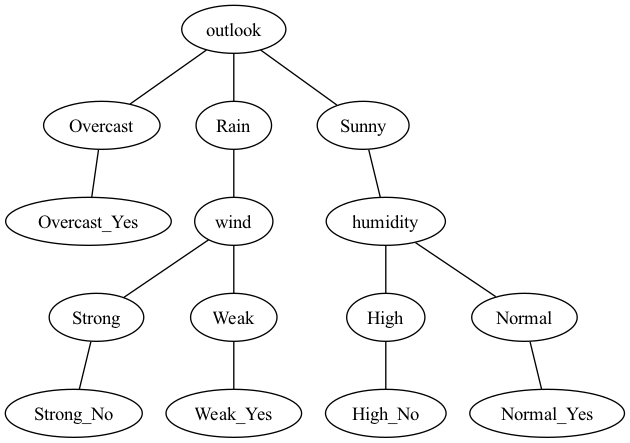

In [128]:
def draw(parent_name, child_name):
    edge = pydot.Edge(parent_name, child_name)
    graph.add_edge(edge)

def visit(node, parent=None):
    for k,v in node.items():
        if isinstance(v, dict):
            if parent:
                draw(parent, k)
            visit(v, k)
        else:
            draw(parent, k)
            draw(k, k+"_"+v)

graph = pydot.Dot(graph_type='graph')
visit(dtree)
tree_plot = Image(graph.create_png())
display(tree_plot)